# Libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [165]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Loading

In [18]:
stream_df = pd.read_csv('datasets/tracks_df_cleaned.csv')
print(stream_df.columns, stream_df.shape)

Index(['ts', 'platform', 'ms_played', 'conn_country', 'track_name',
       'artist_name', 'album_name', 'track_id', 'reason_start', 'reason_end',
       'shuffle', 'skipped', 'offline', 'incognito_mode', 'ts_local', 'hour',
       'day_of_week_str', 'day_of_week_int', 'local_date', 'local_month',
       'local_year', 'duration_ms', 'ms_played_ratio', 'is_skipped'],
      dtype='object') (129393, 24)


In [19]:
stream_df.isna().sum()

ts                     0
platform               0
ms_played              0
conn_country           0
track_name             0
artist_name            0
album_name             0
track_id               0
reason_start           0
reason_end         20538
shuffle                0
skipped                0
offline                0
incognito_mode         0
ts_local               0
hour                   0
day_of_week_str        0
day_of_week_int        0
local_date             0
local_month            0
local_year             0
duration_ms            0
ms_played_ratio        0
is_skipped             0
dtype: int64

# Feature Engineering

## aggregate the data into daily level

In [22]:
# get the columns that we might need only
stream_df = stream_df[['track_id', 'local_year', 'local_month', 'local_date', \
                        'artist_name', 'track_name', 'ms_played', 'duration_ms', \
                            'day_of_week_int', 'shuffle']].copy()

In [23]:
stream_df.columns

Index(['track_id', 'local_year', 'local_month', 'local_date', 'artist_name',
       'track_name', 'ms_played', 'duration_ms', 'day_of_week_int', 'shuffle'],
      dtype='object')

In [24]:
stream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129393 entries, 0 to 129392
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   track_id         129393 non-null  object
 1   local_year       129393 non-null  int64 
 2   local_month      129393 non-null  int64 
 3   local_date       129393 non-null  int64 
 4   artist_name      129393 non-null  object
 5   track_name       129393 non-null  object
 6   ms_played        129393 non-null  int64 
 7   duration_ms      129393 non-null  int64 
 8   day_of_week_int  129393 non-null  int64 
 9   shuffle          129393 non-null  bool  
dtypes: bool(1), int64(6), object(3)
memory usage: 9.0+ MB


In [25]:
# convert the column into its appropriate data type
stream_df['local_date'] = stream_df['local_date'].astype(str).str.zfill(2)
stream_df['local_month'] = stream_df['local_month'].astype(str).str.zfill(2)
stream_df['local_year'] = stream_df['local_year'].astype(str)

stream_df['local_datetime'] = pd.to_datetime(stream_df['local_year'] + '-' + stream_df['local_month'] + '-' + stream_df['local_date'])
stream_df.drop(['local_year', 'local_month', 'local_date'], axis=1, inplace=True)

In [26]:
# aggregate the data into daily
agg_stream_df = stream_df.groupby(['local_datetime', 'track_id']).agg(
    artist_name = ('artist_name', 'first'),
    track_name = ('track_name', 'first'),
    ms_played = ('ms_played', 'sum'),
    duration_ms = ('duration_ms', 'first'),
    day_of_week = ('day_of_week_int', 'first'),
    times_played = ('track_id', 'count'),
    shuffle = ('shuffle', 'first')
).reset_index()

In [27]:
# calculate the ms_played_ratio
agg_stream_df['ms_played_ratio'] = agg_stream_df['ms_played'] / agg_stream_df['duration_ms']

### (additional) times_played vs ms_played_ratio?
you might be thinking, "why not just use the times_played?"
well, the reason is ms_played_ratio is an indicator of how much the user is actually listening to the song instead of just clicking on it and skipping it.
it's a bit redundant i suppose but it's a good indicator of user engagement.

In [28]:
agg_stream_df.shape

(56168, 10)

## (optional) further cleaning

In [29]:
# there are some rows with 0 duration_ms which is not possible, so we will remove them
agg_stream_df = agg_stream_df[~((agg_stream_df['duration_ms'] == 0) | (agg_stream_df['ms_played_ratio'] == np.inf))].copy()

In [34]:
print(agg_stream_df.shape)

(56166, 10)


## identifying 'churn' criteria

before we add more features, we need to define the churn criteria. In this case, we will define churn based on the number of days since the last activity of the track and the listening trend.

In [35]:
agg_stream_df.sample(5)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio
15972,2019-04-16,0UeYCHOETPfai02uskjJ3x,Bag Raiders,Shooting Stars,235813,235813,1,1,True,1.000000
39616,2022-06-16,3G6hD9B2ZHOsgf4WfNu7X1,Lorde,Team,4976,193058,3,2,True,0.025775
43772,2022-10-29,0O4sIQ728ugLlwBVaxF8UM,Japanese Breakfast,"Kokomo, IN",11703,218744,5,1,False,0.053501
22818,2020-04-09,21vwWfS6qvxh8TN3lgHvZr,Bishop Briggs,Baby,194000,194000,3,1,True,1.000000
29321,2021-03-06,0MPJ76s0uath1HDrR0aLg3,Daniela Andrade,Falling in Love at a Coffee Shop,227438,226500,5,3,True,1.004141


In [36]:
# calculate the difference between consecutive stream for each track daily
def calculate_differences(df):
    df['prev_play_time'] = df.groupby('track_id')['local_datetime'].shift(1)
    df['time_diff'] = df['local_datetime'] - df['prev_play_time']

    df['prev_ms_played'] = df.groupby('track_id')['ms_played'].shift(1)
    df['duration_change'] = df['ms_played'] - df['prev_ms_played']
    
    df['prev_ratio'] = df.groupby('track_id')['ms_played_ratio'].shift(1)
    df['ratio_change'] = df['ms_played_ratio'] - df['prev_ratio']

    # remove the unused columns
    df.drop(['prev_play_time', 'prev_ms_played', 'prev_ratio'], axis=1, inplace=True)
    
    return df

In [37]:
agg_stream_interactions = calculate_differences(agg_stream_df.copy())
agg_stream_interactions.sample(5)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change
48069,2023-03-06,7a9udNo0GU97xnMAkjLdmE,dodie,Sick of Losing Soulmates,267484,267300,0,2,True,1.000688,5 days,184.0,0.000688
15756,2019-04-11,1M1aKmgUXpmWZi43u8sJn4,Shawn Wasabi,Marble Soda,161919,161919,3,1,True,1.000000,2 days,-161919.0,-1.000000
14048,2019-01-16,3OyQu1h7VXpormoMRYTjuk,Bishop Briggs,Dream - RAMI Remix,167280,167280,2,1,True,1.000000,5 days,-840.0,-0.005022
43889,2022-10-29,7BoVAJ0HuKcBBRmUGlzX6o,Rina Sawayama,LUCID,0,218706,5,1,False,0.000000,139 days,-288881.0,-1.320865
39824,2022-06-22,1kqc6U8hVYZhY0gFGQclCz,girl in red,girls,396800,198400,2,2,False,2.000000,2 days,0.0,0.000000


### churn by number of days since the last time track is played

In [38]:
time_diff_days = agg_stream_interactions['time_diff'].dropna().dt.days
time_diff_days[time_diff_days < 30].describe()


count    45827.000000
mean         4.018308
std          5.126654
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         29.000000
Name: time_diff, dtype: float64

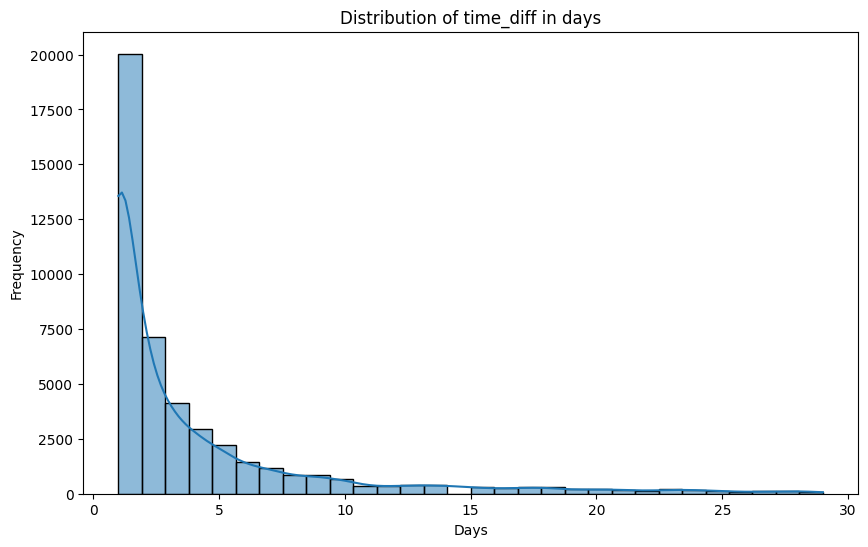

In [39]:
# visualize the distribution of time_diff with less than 30 days
plt.figure(figsize=(10, 6))
sns.histplot(time_diff_days[time_diff_days < 30], bins=30, kde=True)
plt.title('Distribution of time_diff in days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [40]:
quantiles = time_diff_days.quantile([0.25, 0.5, 0.75, 0.9, 0.95])
quantiles

0.25     1.0
0.50     2.0
0.75     7.0
0.90    30.0
0.95    79.0
Name: time_diff, dtype: float64

Here I think that the churn criteria is when the track has not been played for 7 days (0.75 quantile).

In [41]:
# let's label the data into churned and not churned based on criteria we have set
agg_stream_interactions['churned_by_time_diff'] = (agg_stream_interactions['time_diff'] > pd.to_timedelta('7D')).astype(int)

In [42]:
agg_stream_interactions['churned_by_time_diff'].value_counts()

churned_by_time_diff
0    44367
1    11799
Name: count, dtype: int64

### churn by number of ms_played_ratio change

In [43]:
agg_stream_interactions[(agg_stream_interactions['ratio_change'] < 0) &
                    (agg_stream_interactions['ratio_change'] > -10)]['ratio_change'].describe()

count    18584.000000
mean        -1.367194
std          1.502783
min         -9.999871
25%         -1.731661
50%         -0.999925
75%         -0.573260
max         -0.000003
Name: ratio_change, dtype: float64

In [44]:
agg_stream_interactions['ratio_change'].describe()

count    50923.000000
mean        -0.048122
std          5.137591
min       -288.798074
25%         -0.929968
50%          0.000000
75%          0.891122
max        135.249394
Name: ratio_change, dtype: float64

In [45]:
agg_stream_interactions['ratio_change'].quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.05   -3.000000
0.10   -1.808003
0.25   -0.929968
0.50    0.000000
0.75    0.891122
0.90    1.632416
0.95    2.986170
Name: ratio_change, dtype: float64

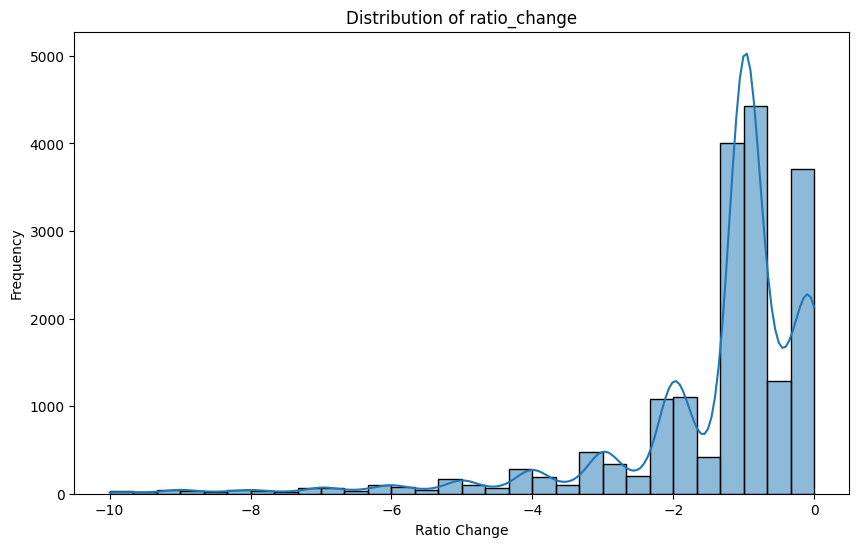

In [46]:
# Visualize the distribution of ratio_change
plt.figure(figsize=(10, 6))
filtered_data = agg_stream_interactions[(agg_stream_interactions['ratio_change'] > -10) 
                                    & (agg_stream_interactions['ratio_change'] < 0)]
sns.histplot(filtered_data['ratio_change'], bins=30, kde=True)
plt.title('Distribution of ratio_change')
plt.xlabel('Ratio Change')
plt.ylabel('Frequency')
plt.show()


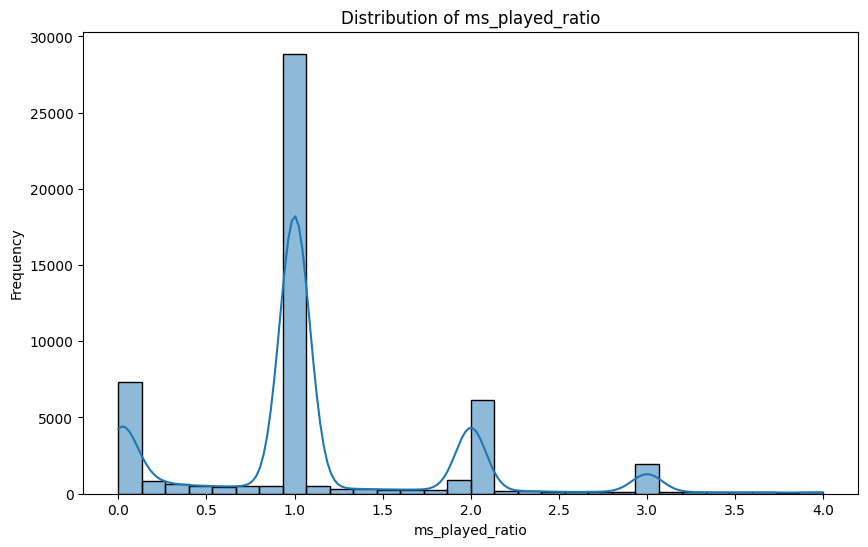

In [47]:
# Visualize the distribution of ratio_change
plt.figure(figsize=(10, 6))
sns.histplot(agg_stream_interactions[agg_stream_interactions['ms_played_ratio'] < 4]['ms_played_ratio'], bins=30, kde=True)
plt.title('Distribution of ms_played_ratio')
plt.xlabel('ms_played_ratio')
plt.ylabel('Frequency')
plt.show()


Here I think that the churn criteria is when the ratio_change change is less than -1.8 (0.1 quantile) and reactivation criteria is when the track is played at least once.

In [48]:
agg_stream_interactions.columns

Index(['local_datetime', 'track_id', 'artist_name', 'track_name', 'ms_played',
       'duration_ms', 'day_of_week', 'times_played', 'shuffle',
       'ms_played_ratio', 'time_diff', 'duration_change', 'ratio_change',
       'churned_by_time_diff'],
      dtype='object')

In [49]:
# label the churn based on ratio_change
def label_churn_by_ratio_change(row):
    if pd.isna(row['ratio_change']):
        return 0 # not churn because we don't have any data to compare/first appearance
    
    if row['ratio_change'] < -1.8:
        return 1
    else:
        if row['ms_played_ratio'] >= 1:
            return 0
        else:
            return 1

In [50]:
agg_stream_interactions['churned_by_ratio_change'] = agg_stream_interactions.apply(label_churn_by_ratio_change, axis=1)

In [51]:
agg_stream_interactions['churned_by_ratio_change'].value_counts()

churned_by_ratio_change
0    41185
1    14981
Name: count, dtype: int64

### let's compare the two criterias

In [52]:
display(agg_stream_interactions[['time_diff', 'ratio_change']].corr(method='pearson'))
display(agg_stream_interactions[['churned_by_time_diff', 'churned_by_ratio_change']].corr(method='pearson'))

,time_diff,ratio_change
time_diff,1.000000,0.004802
ratio_change,0.004802,1.000000


,churned_by_time_diff,churned_by_ratio_change
churned_by_time_diff,1.00000,0.09941
churned_by_ratio_change,0.09941,1.00000


In [53]:
agg_stream_interactions[['churned_by_time_diff', 'churned_by_ratio_change']].value_counts()

churned_by_time_diff  churned_by_ratio_change
0                     0                          33539
                      1                          10828
1                     0                           7646
                      1                           4153
Name: count, dtype: int64

### (optional) looking at the data

looking at both churned_by_time_diff and churned_by_ratio_change, we can interpret it like this: 

(churned_by_time_diff, churned_by_ratio_change)
- (0, 0): not churned, these are tracks that are consistently played and show stable engagement.
- (0, 1): at risk of churn, these are tracks that are played but the engagement is consistently decreasing and might risk of churn.
- (1, 0): inactive, these are tracks that are not played for a long time but are still played (at least most of it).
- (1, 1): churned by both, these are tracks that are not played for a long time and the engagement is consistently decreasing.

In [54]:
# conditions based on churn types
ratio_churned_condition = (agg_stream_interactions['churned_by_time_diff'] == 0) & (agg_stream_interactions['churned_by_ratio_change'] == 1)
time_churned_condition = (agg_stream_interactions['churned_by_time_diff'] == 1) & (agg_stream_interactions['churned_by_ratio_change'] == 0)
total_churned_condition = (agg_stream_interactions['churned_by_time_diff'] == 1) & (agg_stream_interactions['churned_by_ratio_change'] == 1)

In [55]:
def show_rows(df, condition, window=3, n_target=-1):
    # get the index of the conditions
    indices = df[condition].index

    # prepare result dataframe
    result_df = pd.DataFrame()

    # get the rows based on the index up to n_target
    for idx in indices[:n_target]:
        idx_track_id = df.loc[idx, 'track_id']
        idx_local_datetime = df.loc[idx, 'local_datetime']

        # get the rows before and after the index based on the window
        before_rows = df[(df['track_id'] == idx_track_id) & (df['local_datetime'] < idx_local_datetime)].tail(window)
        after_rows = df[(df['track_id'] == idx_track_id) & (df['local_datetime'] > idx_local_datetime)].head(window)

        result_df = pd.concat([result_df, before_rows, df.loc[[idx]], after_rows])

    # Remove duplicates based on specified columns (optional, depends on the use case)
    result_df = result_df.drop_duplicates(subset=['local_datetime', 'track_id', 'artist_name', 'track_name']).reset_index(drop=True)

    return result_df

In [56]:
result = show_rows(agg_stream_interactions, time_churned_condition, window=3)

In [57]:
result.tail(10)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change
26392,2023-11-08,5qijmwAZOkz18fJ1Wu5mY1,Wasia Project,My Vine,376162,188081,2,2,True,2.000000,1 days,-794545.0,-4.224483,0,1
26393,2023-11-16,5qijmwAZOkz18fJ1Wu5mY1,Wasia Project,My Vine,564243,188081,3,3,True,3.000000,8 days,188081.0,1.000000,1,0
26394,2023-11-06,6FDzlEOK29XWew1qfnGhaU,Wasia Project,impossible,539000,269500,0,2,True,2.000000,1 days,269500.0,1.000000,0,0
26395,2023-11-07,6FDzlEOK29XWew1qfnGhaU,Wasia Project,impossible,1886500,269500,1,7,True,7.000000,1 days,1347500.0,5.000000,0,0
26396,2023-11-08,6FDzlEOK29XWew1qfnGhaU,Wasia Project,impossible,808500,269500,2,3,True,3.000000,1 days,-1078000.0,-4.000000,0,1
26397,2023-11-16,6FDzlEOK29XWew1qfnGhaU,Wasia Project,impossible,1078000,269500,3,4,True,4.000000,8 days,269500.0,1.000000,1,0
26398,2023-11-06,6WrV6G0sfh86sZVwSLGUh3,Wasia Project,U Deserve,436766,218383,0,2,True,2.000000,1 days,218383.0,1.000000,0,0
26399,2023-11-07,6WrV6G0sfh86sZVwSLGUh3,Wasia Project,U Deserve,1310298,218383,1,6,True,6.000000,1 days,873532.0,4.000000,0,0
26400,2023-11-08,6WrV6G0sfh86sZVwSLGUh3,Wasia Project,U Deserve,786913,218383,2,4,True,3.603362,1 days,-523385.0,-2.396638,0,1
26401,2023-11-16,6WrV6G0sfh86sZVwSLGUh3,Wasia Project,U Deserve,655149,218383,3,3,True,3.000000,8 days,-131764.0,-0.603362,1,0


### finalizing the churn labelling

In [58]:
agg_stream_interactions['churned'] = agg_stream_interactions['churned_by_time_diff'] & agg_stream_interactions['churned_by_ratio_change']

In [59]:
agg_stream_interactions['churned'].value_counts()

churned
0    52013
1     4153
Name: count, dtype: int64

In [60]:
agg_stream_interactions.tail(20)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change,churned
56148,2023-11-16,5hQjB552fc7TQAtdzJTzLo,beabadoobee,Emo Song,220038,218684,3,2,False,1.006192,NaT,NaN,NaN,0,0,0
56149,2023-11-16,5qijmwAZOkz18fJ1Wu5mY1,Wasia Project,My Vine,564243,188081,3,3,True,3.000000,8 days,188081.0,1.000000,1,0,0
56150,2023-11-16,60aYO1uRqTkGltYtaMFPxy,beabadoobee,Don’t get the deal,223979,220693,3,2,False,1.014889,1 days,170559.0,0.772834,0,0,0
56151,2023-11-16,64OcVQq3FBoGm2twUd3044,Lawrence,Homesick,198026,198026,3,1,True,1.000000,2 days,0.0,0.000000,0,0,0
56152,2023-11-16,69kRf3P6QDiK0ZAFw70KUR,beabadoobee,Soren - Bedroom Session,80435,193810,3,1,False,0.415020,NaT,NaN,NaN,0,0,0
56153,2023-11-16,69klmXiY3N1xUwVFzZArzJ,Lawrence,Make A Move,259786,259786,3,1,True,1.000000,2 days,-274385.0,-1.056196,0,0,0
56154,2023-11-16,6F5mZpEEjhsAW8UEqbIpz1,beabadoobee,Tired,199514,199514,3,1,False,1.000000,1 days,0.0,0.000000,0,0,0
56155,2023-11-16,6FDzlEOK29XWew1qfnGhaU,Wasia Project,impossible,1078000,269500,3,4,True,4.000000,8 days,269500.0,1.000000,1,0,0
56156,2023-11-16,6PvxbkegGnVGxd1NDYS6fZ,beabadoobee,He Gets Me So High,165682,165682,3,1,False,1.000000,1 days,0.0,0.000000,0,0,0
56157,2023-11-16,6UAmzHUw9ZW7jPxQtcWs7G,Lawrence,Have Yourself a Merry Little Christmas,200155,200155,3,1,True,1.000000,2 days,0.0,0.000000,0,0,0


### dealing with the first play of the track
the first play of the track is a special case where the track is played for the first time and this causes some columns to be NaN or NaT. we will fill these columns with 0 and adding a new column to indicate the first play of the track.

In [61]:
# fill the 'first_play' column as 1 if the track is the first play, otherwise 0
agg_stream_interactions['first_play'] = agg_stream_interactions.groupby('track_id')['local_datetime'].rank(method='first') == 1
agg_stream_interactions['first_play'] = agg_stream_interactions['first_play'].astype(int)

In [62]:
# filling the nan values in time_diff, duration_change, ratio_change with 0
agg_stream_interactions['time_diff'] = agg_stream_interactions['time_diff'].fillna(pd.Timedelta(0))
agg_stream_interactions['duration_change'] = agg_stream_interactions['duration_change'].fillna(0)
agg_stream_interactions['ratio_change'] = agg_stream_interactions['ratio_change'].fillna(0)

In [63]:
# convert the time_diff into int type for easier processing
agg_stream_interactions['time_diff'] = agg_stream_interactions['time_diff'].dt.days

In [64]:
agg_stream_interactions.tail(10)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change,churned,first_play
56158,2023-11-16,6WrV6G0sfh86sZVwSLGUh3,Wasia Project,U Deserve,655149,218383,3,3,True,3.000000,8,-131764.0,-0.603362,1,0,0,0
56159,2023-11-16,6jvx06FhiZWCjBeZdXF91P,beabadoobee,Last Day On Earth,223087,223087,3,1,False,1.000000,1,0.0,0.000000,0,0,0,0
56160,2023-11-16,6kp9czhrGZrP0hr9Y6opEr,beabadoobee,Soren,241944,241944,3,1,False,1.000000,1,237123.0,0.980074,0,0,0,0
56161,2023-11-16,6mZPt7IcgSaqk5H4NX9a6f,beabadoobee,Angel,193253,193253,3,1,False,1.000000,1,126098.0,0.652502,0,0,0,0
56162,2023-11-16,6nwxT0W6u4JYDGK5iyBOYt,Lawrence,Casualty,143893,143893,3,1,True,1.000000,2,-143893.0,-1.000000,0,0,0,0
56163,2023-11-16,6tSXLuWhy6Bjn4BswKyJ24,beabadoobee,Further Away,206064,187653,3,2,False,1.098112,0,0.0,0.000000,0,0,0,1
56164,2023-11-16,77cuLtsUljaHBNpG89GpqE,beabadoobee,broken cd,170280,170280,3,1,False,1.000000,1,0.0,0.000000,0,0,0,0
56165,2023-11-16,7eJMfftS33KTjuF7lTsMCx,Powfu,death bed (coffee for your head),19760,173333,3,1,False,0.114000,1,11093.0,0.063998,0,1,0,0
56166,2023-11-16,7mE5nyoRdlZq7hKW2Uzxkl,Lawrence,Santa Claus Is Comin' to Town,1384,172738,3,1,True,0.008012,2,-344092.0,-1.991988,0,1,0,0
56167,2023-11-16,7yoNS78wCq61PqbfBggqzo,Wasia Project,Burning Eyes R Calling,1254156,313539,3,4,True,4.000000,8,313539.0,1.000000,1,0,0,0


## adding in track features data

In [65]:
tracks_features_df = pd.read_csv('datasets/tracks_features_df.csv')
print(tracks_features_df.columns,tracks_features_df.shape)

Index(['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object') (5238, 13)


In [66]:
tracks_features_df.head(5)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,6tAM5c0bJOwRqGAEgiNMpI,0.446,0.823,11,-5.279,0,0.0859,0.002560,0.07480,0.1170,0.263,128.198,4
1,5Q0P0cX3e42PgKd8LLS3ms,0.402,0.856,1,-4.256,1,0.0659,0.005040,0.01640,0.2530,0.247,140.028,4
2,4VrdksXJVhAOLW49qV0VTQ,0.426,0.915,11,-3.881,0,0.1430,0.000899,0.10800,0.4950,0.271,130.405,4
3,0ng42pTjKgskmobNzhnEUa,0.434,0.839,8,-4.493,1,0.1190,0.028400,0.00103,0.6050,0.400,127.670,4
4,1ip1SN4tWX0qMgE1KgIF52,0.457,0.911,1,-3.315,1,0.0498,0.003390,0.59200,0.0752,0.330,175.002,4


In [67]:
tracks_features_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000
mean,0.585549,0.501807,5.153112,-10.085214,0.675449,0.073143,0.463490,0.322635,0.172504,0.417283,120.521539,3.895380
std,0.151758,0.274129,3.565723,5.471854,0.468252,0.077542,0.366215,0.402799,0.136017,0.254099,31.965488,0.442765
min,0.000000,0.000138,0.000000,-38.169000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.492000,0.263000,2.000000,-13.559000,0.000000,0.035100,0.075200,0.000003,0.096200,0.196500,95.012250,4.000000
50%,0.599000,0.495000,5.000000,-8.821000,1.000000,0.046000,0.441000,0.006335,0.117000,0.385000,120.028000,4.000000
75%,0.694000,0.748000,8.000000,-5.756500,1.000000,0.073800,0.844000,0.830000,0.199000,0.611000,140.951750,4.000000
max,0.985000,1.000000,11.000000,-0.234000,1.000000,0.960000,0.996000,0.993000,0.965000,0.999000,219.982000,5.000000


In [68]:
# merge the aggregated data with the tracks features
merged_df = agg_stream_interactions.merge(tracks_features_df, on='track_id', how='left')

In [69]:
pd.set_option('display.max_columns', 50)

In [70]:
display(merged_df.sample(5))
display(merged_df.shape, merged_df.columns)

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change,churned,first_play,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
13498,2018-12-13,7dD947TDPVuMUHo0WTfAPy,Bishop Briggs,Pray (Empty Gun),491710,244933,3,3,True,2.007529,1,214660.0,0.876403,0,0,0,0,0.546,0.577,6.0,-7.034,0.0,0.0392,0.0885,0.000003,0.1000,0.219,149.601,4.0
26794,2020-10-04,7pxbZ29k1LJXvOdd2e5Bdn,Us The Duo,Shotgun,174884,174884,6,1,False,1.000000,2,0.0,0.000000,0,0,0,0,0.806,0.263,5.0,-10.430,1.0,0.0502,0.7870,0.000000,0.1820,0.868,115.854,4.0
46503,2023-01-28,7o8vTKpUe6GvlssjGhZk7d,dodie,Human,117631,202721,5,1,True,0.580261,5,-85090.0,-0.419739,0,1,0,0,0.665,0.287,8.0,-14.923,1.0,0.0400,0.9380,0.149000,0.1030,0.386,133.924,4.0
3253,2017-06-16,6Lr6YaV8KW41iD53PgjPr5,In Love With a Ghost,Chilling At Nemu's Place,46315,46315,4,1,True,1.000000,2,0.0,0.000000,0,0,0,0,0.943,0.406,8.0,-10.715,0.0,0.0876,0.5560,0.719000,0.0913,0.991,109.055,4.0
43897,2022-10-30,0H2aPW6EdKHfOZ9AzVnod4,Tessa Violet,Bored,183639,183380,6,2,False,1.001412,1,44868.0,0.244672,0,0,0,0,0.838,0.757,11.0,-6.206,0.0,0.0863,0.0788,0.000000,0.0442,0.729,126.019,4.0


(56166, 29)

Index(['local_datetime', 'track_id', 'artist_name', 'track_name', 'ms_played',
       'duration_ms', 'day_of_week', 'times_played', 'shuffle',
       'ms_played_ratio', 'time_diff', 'duration_change', 'ratio_change',
       'churned_by_time_diff', 'churned_by_ratio_change', 'churned',
       'first_play', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [71]:
merged_df.isna().sum()

local_datetime              0
track_id                    0
artist_name                 0
track_name                  0
ms_played                   0
duration_ms                 0
day_of_week                 0
times_played                0
shuffle                     0
ms_played_ratio             0
time_diff                   0
duration_change             0
ratio_change                0
churned_by_time_diff        0
churned_by_ratio_change     0
churned                     0
first_play                  0
danceability               10
energy                     10
key                        10
loudness                   10
mode                       10
speechiness                10
acousticness               10
instrumentalness           10
liveness                   10
valence                    10
tempo                      10
time_signature             10
dtype: int64

In [72]:
# show the rows with null values
merged_df[merged_df['liveness'].isna()]

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change,churned,first_play,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1,2016-05-14,1KzLyjpjIRHuuj4iX8QsC2,Monstercat,Monstercat Podcast EP. 100,4685,9744610,5,1,False,0.000481,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-05-14,4mjgNE8R31AzxWfPNGtVMf,Monstercat,Best of 2015 (Album Mix),5614,9158194,5,1,False,0.000613,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-05-14,6jvMmRtSzoEibQGrQkSISQ,Monstercat,Monstercat Best of 2012,3677,6348017,5,1,False,0.000579,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31815,2021-08-19,1GgLReaorohPXXy75crpuo,Mavine,Flash,109256,109256,3,1,True,1.000000,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31931,2021-08-20,1GgLReaorohPXXy75crpuo,Mavine,Flash,109256,109256,4,1,True,1.000000,1,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32052,2021-08-21,45IIpiRjf9lKuIdOBQkO71,BVG,Sunday Morning,192023,192023,5,1,True,1.000000,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32287,2021-08-27,5GfOd3Fb8VMHxU3DWgs8fz,softy,Sundown,165420,165428,4,1,True,0.999952,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32325,2021-08-28,1GgLReaorohPXXy75crpuo,Mavine,Flash,109256,109256,5,1,True,1.000000,8,0.0,0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32459,2021-08-29,3WXMrOw2iD9bb5cFNyjif7,BVG,Waterfall,480075,160025,6,3,True,3.000000,0,0.0,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32484,2021-08-29,5GfOd3Fb8VMHxU3DWgs8fz,softy,Sundown,165420,165428,6,1,True,0.999952,2,0.0,0.0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# I guess it's better to remove these rows since we can't impute the missing value and it's only 10 rows
merged_df = merged_df[~merged_df['liveness'].isna()].copy() # let's use 'liveness' column since they came from the same source so they share the same rows

##  adding track popularity and release date

In [75]:
# for this, we need to get the data from tracks_info_df
tracks_info_df = pd.read_csv('datasets/tracks_info_df.csv')
print(tracks_info_df.columns,tracks_info_df.shape)

Index(['track_id', 'name', 'artistName', 'release_date', 'popularity',
       'duration_ms'],
      dtype='object') (5245, 6)


In [76]:
# merge the data with the tracks_info_df
merged_df = merged_df.merge(tracks_info_df[['track_id', 'release_date', 'popularity']], on='track_id', how='left')

In [77]:
merged_df.isna().sum()

local_datetime             0
track_id                   0
artist_name                0
track_name                 0
ms_played                  0
duration_ms                0
day_of_week                0
times_played               0
shuffle                    0
ms_played_ratio            0
time_diff                  0
duration_change            0
ratio_change               0
churned_by_time_diff       0
churned_by_ratio_change    0
churned                    0
first_play                 0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
release_date               0
popularity                 0
dtype: int64

### converting 'release_date' into 'days_since_release'

In [78]:
# find out the 'release_date' with incomplete data (like only year or month)
incomplete_release_date = merged_df[merged_df['release_date'].str.len() < 10]
display(incomplete_release_date[['track_id', 'release_date']].sample(5))
display(incomplete_release_date.shape, incomplete_release_date['track_id'].nunique())

,track_id,release_date
4974,29cp4vju8mOmmPYBwsPtLb,2013
51671,2m17BTWlZq0wtS9cpJsCfM,2011
29822,0GbSslWDNItJQPA788gr20,2017
2303,75imPZaXVxdqNVnRV44KsK,2017
24055,0GbSslWDNItJQPA788gr20,2017


(2490, 31)

167

In [79]:
# alright, this is a bit ticky, we can try to correct these data by searching the release date from the internet but for now, let's just assign as the first day of the year
merged_df.loc[incomplete_release_date.index, 'release_date'] = merged_df.loc[incomplete_release_date.index, 'release_date'].str[:4] + '-01-01'

# convert the release_date into datetime
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'])

#  since the data is collected on 2023-11-16 (based on the tail of the data), we can calculate the days since the release data based on the data collection date
merged_df['days_since_release'] = (pd.to_datetime('2023-11-16') - merged_df['release_date']).dt.days

In [80]:
merged_df[['artist_name', 'track_name', 'release_date', 'days_since_release']].sample(5)

,artist_name,track_name,release_date,days_since_release
20035,Bessie Turner,Words You Say,2018-04-20,2036
34837,Emiko Shiratori,Melodies Of Life ~Final Fantasy,2000-01-01,8720
47764,dodie,anything (demo),2021-05-07,923
38673,Chilli Beans.,シェキララ,2021-08-25,813
21139,kobasolo,Summer love,2019-03-26,1696


In [83]:
merged_df.dtypes

local_datetime             datetime64[ns]
track_id                           object
artist_name                        object
track_name                         object
ms_played                           int64
duration_ms                         int64
day_of_week                         int64
times_played                        int64
shuffle                              bool
ms_played_ratio                   float64
time_diff                           int64
duration_change                   float64
ratio_change                      float64
churned_by_time_diff                int64
churned_by_ratio_change             int64
churned                             int64
first_play                          int64
danceability                      float64
energy                            float64
key                               float64
loudness                          float64
mode                              float64
speechiness                       float64
acousticness                      

## Adding the emotion label of the track (not used)
actually, since the emotion label from track lyrics is not really complete, we will skip this feature for now. (or at least until I can find a better way to get complete lyrics data and re-do the emotion analysis)

## save the data (for now)

In [84]:
# let's save the data for now
merged_df.to_csv('datasets/aggregated_data_for_churn_analysis.csv', index=False)

# Exploratory Data Analysis (EDA)

In [193]:
# for the sake of clarity, let's reload the data (optional, only if you skipped the previous step)
merged_df = pd.read_csv('datasets/aggregated_data_for_churn_analysis.csv')

In [194]:
display(merged_df.sample(5))

,local_datetime,track_id,artist_name,track_name,ms_played,duration_ms,day_of_week,times_played,shuffle,ms_played_ratio,time_diff,duration_change,ratio_change,churned_by_time_diff,churned_by_ratio_change,churned,first_play,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,popularity,days_since_release
23532,2020-05-28,6kQ9Os7x5LJ2jLHb8VWKaa,Aimer,ninelie,2328,261773,3,1,True,0.008893,359,1468.0,0.005608,1,1,1,0,0.462,0.850,6.0,-5.558,0.0,0.0453,0.0256,0.000019,0.0756,0.206,172.063,4.0,2016-01-01,0,2876
6185,2017-11-16,3PqWJMsNn4yh9lFqBbYhuE,In Love With a Ghost,Sorry for Not Answering the Phone I'm Too Busy...,132413,132413,3,1,True,1.000000,1,-8717.0,-0.065832,0,0,0,0,0.476,0.161,1.0,-16.368,1.0,0.2120,0.8470,0.000000,0.0331,0.330,96.690,5.0,2017-10-23,48,2215
38003,2022-02-06,7LJHiGtFoF8aJ9A9XfPowz,Lawrence Walther,Feathers,156503,156510,6,1,True,0.999955,0,0.0,0.000000,0,0,0,1,0.532,0.127,4.0,-17.074,0.0,0.0621,0.9030,0.955000,0.1350,0.354,59.973,4.0,2021-12-16,11,700
48043,2023-03-05,73ldtXyp1E5sHdSlSuV3Pq,Orla Gartland,Madison (orla & friends version),682844,228618,6,3,True,2.986834,8,623100.0,2.725507,1,0,0,0,0.760,0.220,5.0,-9.343,1.0,0.0371,0.4830,0.000000,0.2930,0.363,99.975,4.0,2021-12-01,28,715
22445,2020-03-09,0XyeD5XgusMHQlEVlUfxSn,Bishop Briggs,Wild Horses,189336,189346,0,1,True,0.999947,4,-189336.0,-0.999947,0,1,0,0,0.718,0.570,8.0,-4.991,1.0,0.0311,0.2610,0.000000,0.1360,0.229,140.036,4.0,2017-04-14,38,2407


**The data includes the following informations:**
- **track information**: columns related to the track information such as track_id, artist_name, track_name, duration_ms, release_date, popularity, and days_since_release
- **track features**: columns related to the track features such as danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and time_signature
- **daily listening trend**: columns related to the daily listening trend such as day_of_week, shuffle, times_played, ms_played, ms_played_ratio, time_diff (days_since_last_played) and ratio_change
- **additional indicators**: columns related to the additional indicators such as first_play
- **churn label**: columns related to the churn label such as churned_by_time_diff, churned_by_ratio_change, and churned

In [195]:
# that's a lot of columns, let's try to reduce the columns to the important ones
important_columns = ['ms_played', 'duration_ms', 'day_of_week', 'times_played', 'shuffle', 'popularity', 'days_since_release', \
                     'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',\
                     'ms_played_ratio', 'time_diff', 'ratio_change', 'first_play', 'churned']

In [196]:
merged_df = merged_df[important_columns].copy()

In [197]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ms_played           56156 non-null  int64  
 1   duration_ms         56156 non-null  int64  
 2   day_of_week         56156 non-null  int64  
 3   times_played        56156 non-null  int64  
 4   shuffle             56156 non-null  bool   
 5   popularity          56156 non-null  int64  
 6   days_since_release  56156 non-null  int64  
 7   danceability        56156 non-null  float64
 8   energy              56156 non-null  float64
 9   key                 56156 non-null  float64
 10  loudness            56156 non-null  float64
 11  mode                56156 non-null  float64
 12  speechiness         56156 non-null  float64
 13  instrumentalness    56156 non-null  float64
 14  liveness            56156 non-null  float64
 15  valence             56156 non-null  float64
 16  temp

In [198]:
merged_df.isna().sum()

ms_played             0
duration_ms           0
day_of_week           0
times_played          0
shuffle               0
popularity            0
days_since_release    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
ms_played_ratio       0
time_diff             0
ratio_change          0
first_play            0
churned               0
dtype: int64

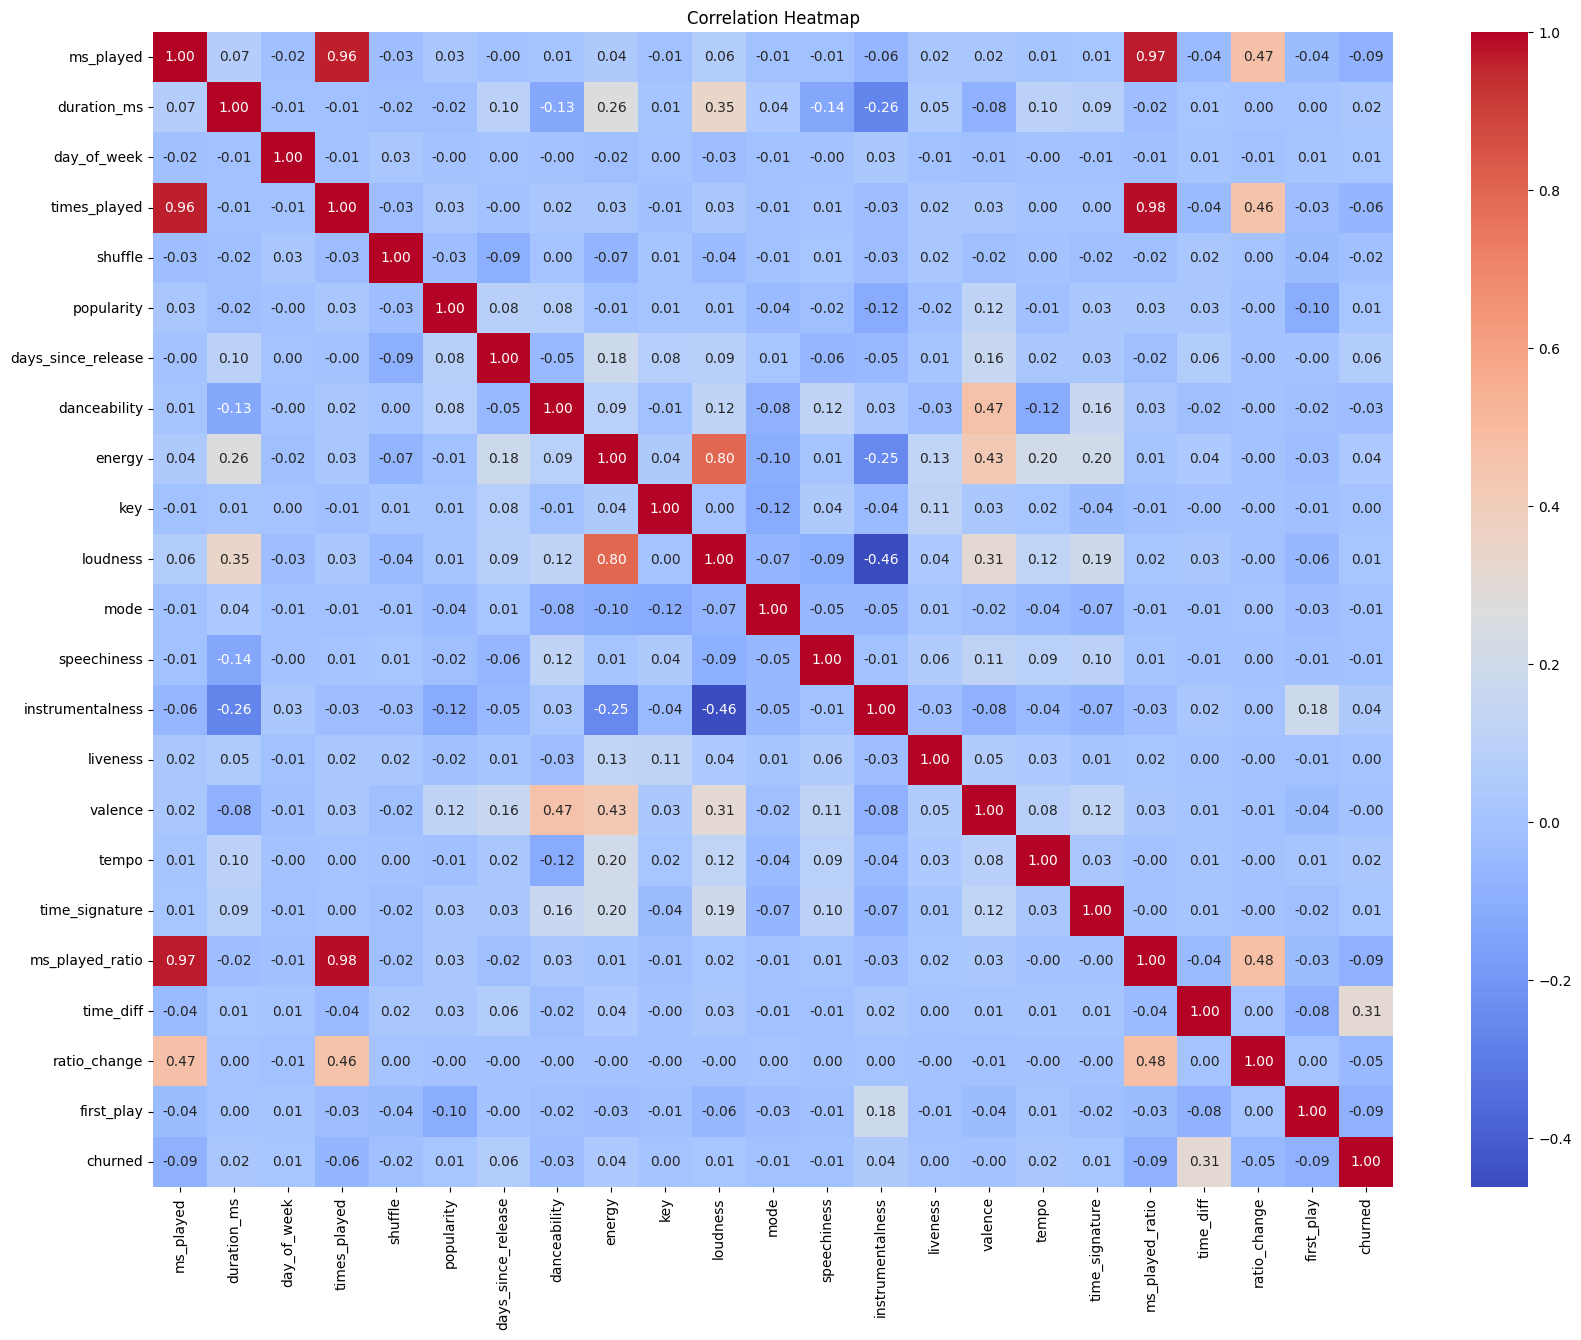

In [199]:
# let's see the correlation of the features
plt.figure(figsize=(20, 15))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [200]:
merged_df[merged_df['times_played'] > 100]

,ms_played,duration_ms,day_of_week,times_played,shuffle,popularity,days_since_release,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,time_signature,ms_played_ratio,time_diff,ratio_change,first_play,churned
5357,18173399,171182,0,108,False,13,3433,0.932,0.346,4.0,-9.577,0.0,0.0588,0.574000,0.0830,0.472,130.042,4.0,106.164194,1,41.096920,0,0
5746,29002623,239600,2,127,True,85,4560,0.733,0.710,5.0,-5.849,0.0,0.0292,0.115000,0.0956,0.965,127.975,4.0,121.046006,2,118.046006,0,0
6271,16417544,148500,0,114,True,37,2138,0.930,0.396,0.0,-10.880,1.0,0.0978,0.117000,0.3530,0.573,121.253,3.0,110.555852,1,109.555852,0,0
6281,15049583,148500,2,106,True,37,2138,0.930,0.396,0.0,-10.880,1.0,0.0978,0.117000,0.3530,0.573,121.253,3.0,101.343993,1,70.617892,0,0
7632,19263864,207360,5,103,False,0,2876,0.621,0.533,1.0,-5.974,1.0,0.0342,0.000000,0.3330,0.791,96.981,4.0,92.900579,1,65.864757,0,0
8388,14644874,122790,6,124,False,58,2291,0.833,0.642,9.0,-6.338,1.0,0.0611,0.000005,0.2510,0.584,86.017,4.0,119.267644,1,70.487515,0,0
13542,24226577,193986,0,130,True,44,2036,0.782,0.762,7.0,-5.437,0.0,0.0350,0.000017,0.1070,0.650,127.049,4.0,124.888275,1,83.707850,0,0
15957,20111957,198800,0,106,False,57,3452,0.374,0.383,0.0,-9.347,1.0,0.0298,0.000094,0.1300,0.203,70.131,4.0,101.166786,1,27.487485,0,0
22844,28485716,139844,4,206,True,69,2036,0.460,0.564,9.0,-10.329,0.0,0.0343,0.000000,0.1910,0.962,135.178,5.0,203.696376,0,0.000000,1,0
23533,14532108,134613,3,112,True,28,5336,0.364,0.868,2.0,-5.419,1.0,0.1300,0.000114,0.1730,0.329,107.078,4.0,107.954715,1,102.950146,0,0


In [174]:
ms_played_threshold = merged_df['ms_played'].quantile(0.95)
times_played_threshold = merged_df['times_played'].quantile(0.95)
time_diff_threshold = merged_df['time_diff'].quantile(0.95)

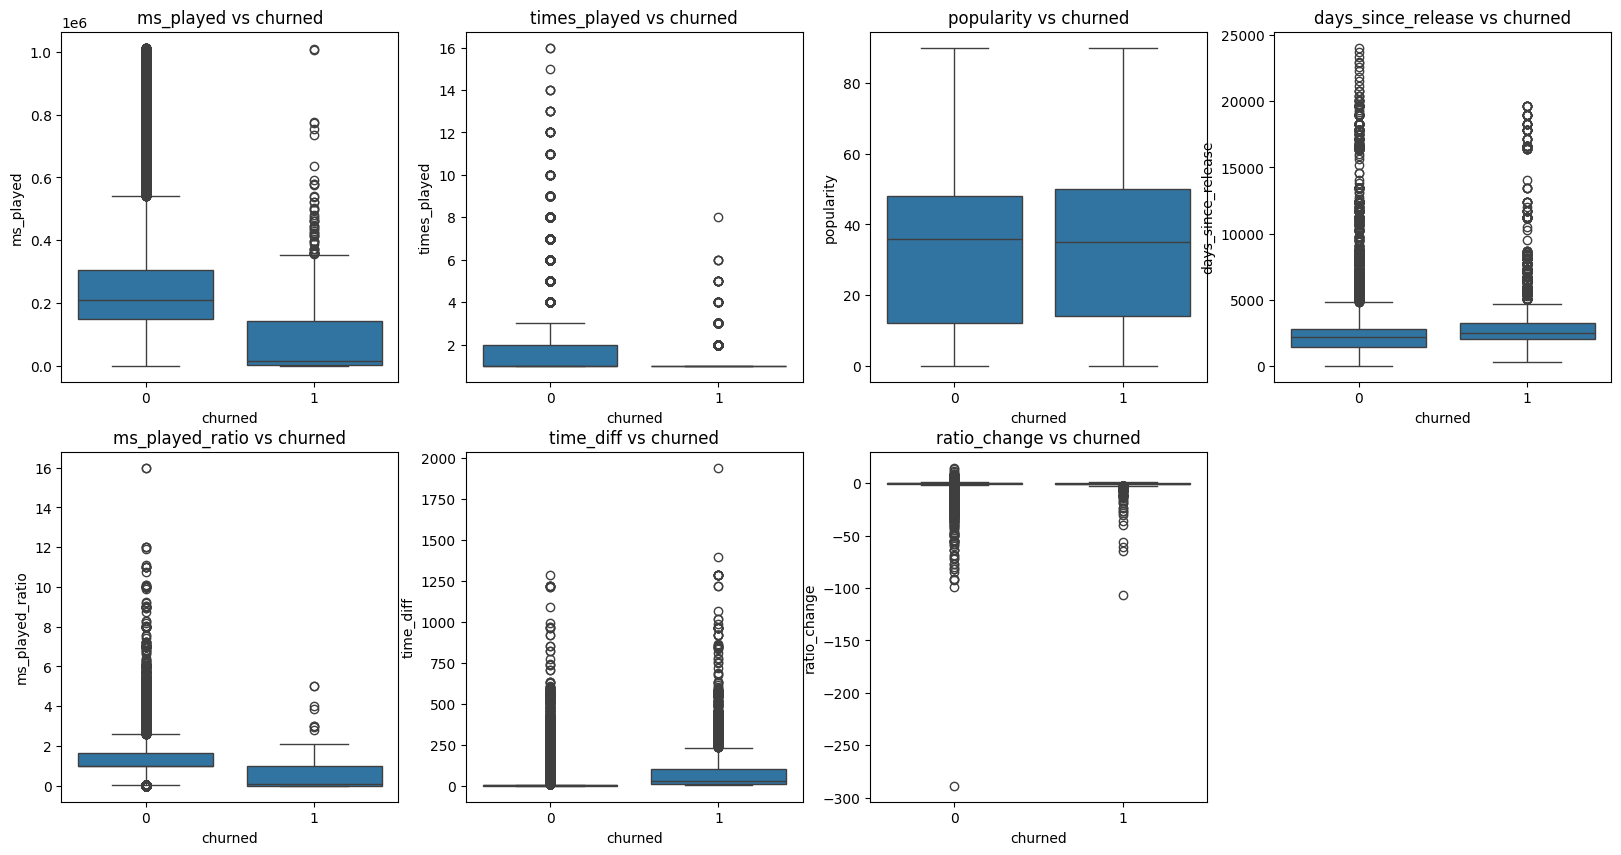

In [158]:
# boxplot for track features based on churned
plt.figure(figsize=(20, 10))
for i, col in enumerate(['ms_played', 'times_played', 'popularity', 'days_since_release', 'ms_played_ratio', 'time_diff', 'ratio_change']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='churned', y=col, data=merged_df[merged_df['ms_played'] < ms_played_threshold])
    plt.title(f'{col} vs churned')

In [201]:
merged_df.columns

Index(['ms_played', 'duration_ms', 'day_of_week', 'times_played', 'shuffle',
       'popularity', 'days_since_release', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'ms_played_ratio', 'time_diff',
       'ratio_change', 'first_play', 'churned'],
      dtype='object')

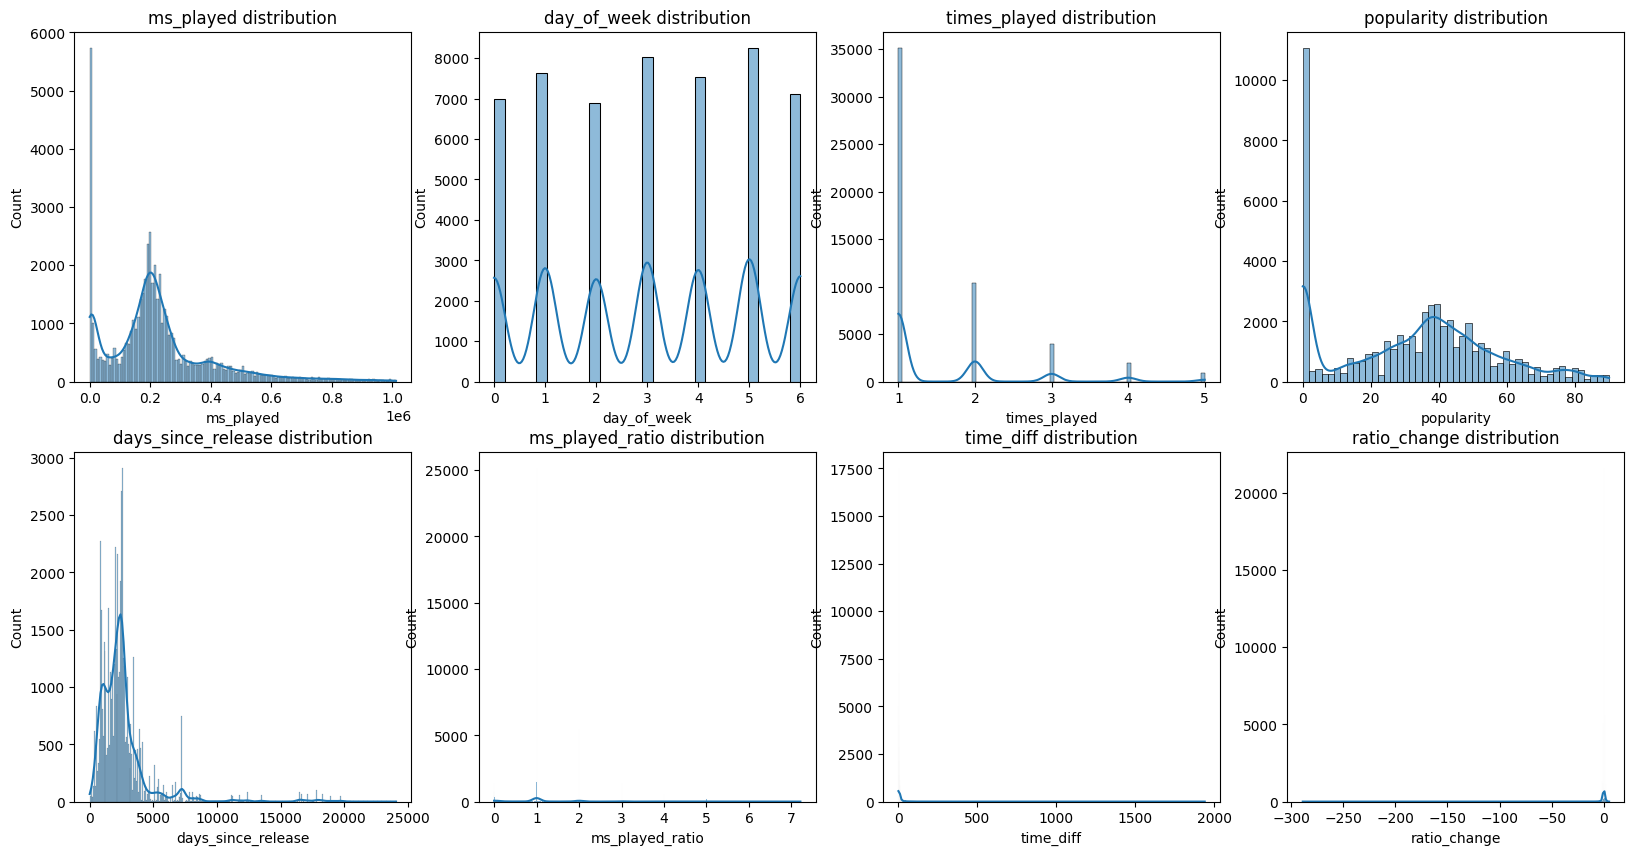

In [204]:
# display the distribution for each features
plt.figure(figsize=(20, 10))

for i, col in enumerate(['ms_played', 'day_of_week', 'times_played', 'popularity', 'days_since_release', 'ms_played_ratio', 'time_diff', 'ratio_change']):
    plt.subplot(2, 4, i+1)
    sns.histplot(merged_df[(merged_df['ms_played'] < ms_played_threshold) & (merged_df['times_played'] < times_played_threshold)][col], kde=True)
    plt.title(f'{col} distribution')

Text(0.5, 1.0, 'Distribution of time_diff based on day_of_week')

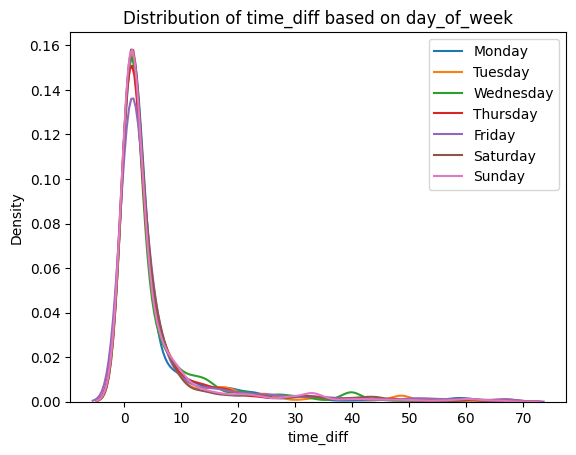

In [175]:
day_of_week_color = sns.color_palette("tab10", merged_df['day_of_week'].nunique())

# kde plot for day_of_week
for i in range(7):
    ax = sns.kdeplot(merged_df[(merged_df['day_of_week'] == i) & (merged_df['time_diff'] < time_diff_threshold)]['time_diff'], color=day_of_week_color[i], label=f'Day {i}', fill=False)

ax.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title('Distribution of time_diff based on day_of_week')


Text(0.5, 1.0, 'Distribution of ms_played based on day_of_week')

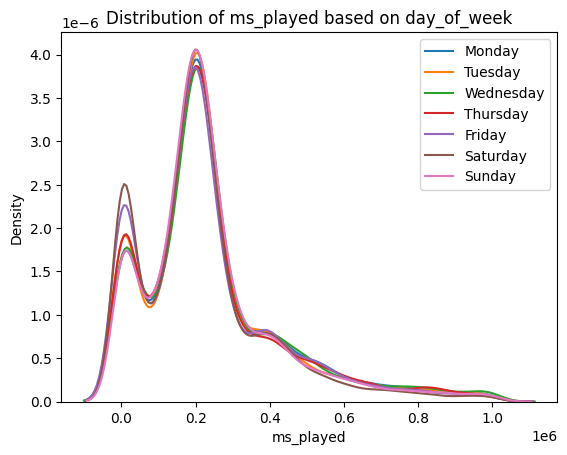

In [171]:
day_of_week_color = sns.color_palette("tab10", merged_df['day_of_week'].nunique())

# kde plot for day_of_week
for i in range(7):
    ax = sns.kdeplot(merged_df[(merged_df['day_of_week'] == i) & (merged_df['ms_played'] < ms_played_threshold)]['ms_played'], color=day_of_week_color[i], label=f'Day {i}', fill=False)

ax.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title('Distribution of ms_played based on day_of_week')


Text(0.5, 1.0, 'Distribution of ms_played based on churned')

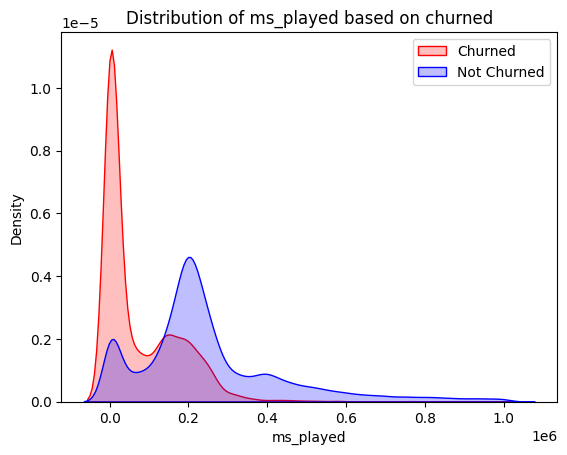

In [172]:
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 1) & (merged_df['ms_played'] < ms_played_threshold)]['ms_played'], color='r', label='ms_played', fill=True)
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 0) & (merged_df['ms_played'] < ms_played_threshold)]['ms_played'], color='b', label='ms_played', fill=True)
ax.legend(['Churned', 'Not Churned'])
ax.set_title('Distribution of ms_played based on churned')

Text(0.5, 1.0, 'Distribution of time_diff based on churned')

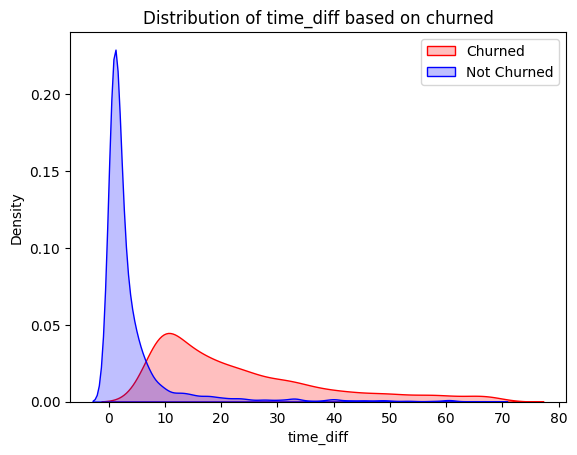

In [176]:
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 1) & (merged_df['time_diff'] < time_diff_threshold)]['time_diff'], color='r', label='time_diff', fill=True)
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 0) & (merged_df['time_diff'] < time_diff_threshold)]['time_diff'], color='b', label='time_diff', fill=True)
ax.legend(['Churned', 'Not Churned'])
ax.set_title('Distribution of time_diff based on churned')

Text(0.5, 1.0, 'Distribution of times_played based on churned')

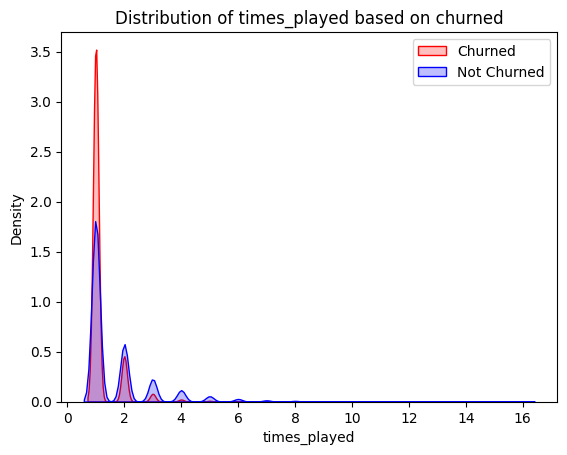

In [218]:
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 1) & (merged_df['ms_played'] < ms_played_threshold)]['times_played'], color='r', label='times_played', fill=True)
ax = sns.kdeplot(merged_df[(merged_df['churned'] == 0) & (merged_df['ms_played'] < ms_played_threshold)]['times_played'], color='b', label='times_played', fill=True)
ax.legend(['Churned', 'Not Churned'])
ax.set_title('Distribution of times_played based on churned')

### (optional) feature importance analysis + feature interaction

In [208]:
merged_df['popularity_times_played'] = merged_df['popularity'] * merged_df['times_played']
merged_df['time_diff_ratio_change'] = merged_df['time_diff'] * merged_df['ratio_change']
merged_df['popularity_days_since_release'] = merged_df['popularity'] * merged_df['days_since_release']

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming merged_df is your dataset and 'churned' is your target column
# Define your features (X) and target (y)
X = merged_df.drop(columns=['churned'])
y = merged_df['churned']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


                          Feature  Importance
19                      time_diff    0.372112
18                ms_played_ratio    0.254468
23         time_diff_ratio_change    0.174209
20                   ratio_change    0.069883
0                       ms_played    0.064442
21                     first_play    0.008739
3                    times_played    0.006594
1                     duration_ms    0.005715
6              days_since_release    0.004611
22        popularity_times_played    0.004239
13               instrumentalness    0.004105
10                       loudness    0.003374
24  popularity_days_since_release    0.003266
8                          energy    0.003258
2                     day_of_week    0.002749
12                    speechiness    0.002697
7                    danceability    0.002694
16                          tempo    0.002631
15                        valence    0.002605
14                       liveness    0.002477
5                      popularity 

# Data Preprocessing
there's not much to do here since we've done most of the preprocessing in the feature engineering step but we still need to do some final touches.

In [177]:
merged_df.columns

Index(['ms_played', 'duration_ms', 'day_of_week', 'times_played', 'shuffle',
       'popularity', 'days_since_release', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'ms_played_ratio', 'time_diff',
       'ratio_change', 'first_play', 'churned'],
      dtype='object')

In [178]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ms_played           56156 non-null  int64  
 1   duration_ms         56156 non-null  int64  
 2   day_of_week         56156 non-null  int64  
 3   times_played        56156 non-null  int64  
 4   shuffle             56156 non-null  bool   
 5   popularity          56156 non-null  int64  
 6   days_since_release  56156 non-null  int64  
 7   danceability        56156 non-null  float64
 8   energy              56156 non-null  float64
 9   key                 56156 non-null  float64
 10  loudness            56156 non-null  float64
 11  mode                56156 non-null  float64
 12  speechiness         56156 non-null  float64
 13  instrumentalness    56156 non-null  float64
 14  liveness            56156 non-null  float64
 15  valence             56156 non-null  float64
 16  temp

In [179]:
# converting shuffle into 1 and 0
merged_df['shuffle'] = merged_df['shuffle'].astype(int)

In [190]:
# reducing the dimentionality of the audio features data
from sklearn.decomposition import PCA

audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
pca = PCA(n_components=3)
merged_df[['audio_pc1', 'audio_pc2', 'audio_pc3']] = pca.fit_transform(merged_df[audio_features])

# drop the original audio features
merged_df.drop(audio_features, axis=1, inplace=True)

In [192]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ms_played           56156 non-null  int64  
 1   duration_ms         56156 non-null  int64  
 2   day_of_week         56156 non-null  int64  
 3   times_played        56156 non-null  int64  
 4   shuffle             56156 non-null  int64  
 5   popularity          56156 non-null  int64  
 6   days_since_release  56156 non-null  int64  
 7   ms_played_ratio     56156 non-null  float64
 8   time_diff           56156 non-null  int64  
 9   ratio_change        56156 non-null  float64
 10  first_play          56156 non-null  int64  
 11  churned             56156 non-null  int64  
 12  audio_pc1           56156 non-null  float64
 13  audio_pc2           56156 non-null  float64
 14  audio_pc3           56156 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 6.4 MB
